## PyTorch CEA model
Based on this code: https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb

In [1]:
import time
import types

import torch
import torch.nn as nn

import torchvision
from torchvision import datasets
from torchsummary import summary

%load_ext autoreload
%autoreload 2

In [2]:
debug_vals = types.SimpleNamespace()

### Load Data

In [3]:
from matplotlib.image import imread
from extract_patches import *

In [4]:
img_name = 'ESP_011261_1960_RED0_0.IMG'
images, ids = extract_patches_from_img(img_name, patch_size=256)

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2575: DecompressionBombWarning: Image size (102400000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def imshow(img):
    plt.imshow(np.squeeze(img))

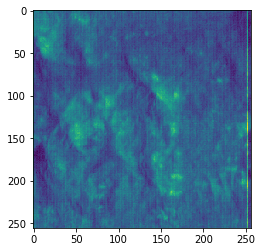

In [6]:
imshow(images[0])

In [7]:
from pytorch_utils import *

tensor_images = numpy_images_to_tensor_dataset(images)

# converting to range 0..1 so it can be decoded by sigmoid activation
tensor_images = tensor_images / 255

In [8]:
tensor_images.size()

torch.Size([1564, 1, 256, 256])

In [10]:
batch_size = 16

dataset = torch.utils.data.TensorDataset(tensor_images)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [11]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Model

In [12]:
from models.ConvAutoencoderV1 import ConvAutoencoderV1

model = ConvAutoencoderV1().to(device)
summary(model, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 100, 256, 256]           2,600
              ReLU-2        [-1, 100, 256, 256]               0
         MaxPool2d-3        [-1, 100, 128, 128]               0
            Conv2d-4        [-1, 200, 128, 128]         500,200
              ReLU-5        [-1, 200, 128, 128]               0
         MaxPool2d-6          [-1, 200, 64, 64]               0
   ConvTranspose2d-7        [-1, 100, 128, 128]         320,100
              ReLU-8        [-1, 100, 128, 128]               0
   ConvTranspose2d-9          [-1, 1, 256, 256]           1,601
          Sigmoid-10          [-1, 1, 256, 256]               0
Total params: 824,501
Trainable params: 824,501
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 194.75
Params size (MB): 3.15
Estimated

In [13]:
learning_rate = 1e-3

In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

In [15]:
num_epochs = 10

In [ ]:
def train_model():
    model.train()

    for epoch in range(num_epochs):
        for i, (data,) in enumerate(loader):
            data = data.to(device)

            # forward
            output = model(data)

            # compute MSE loss
            loss = criterion(output, data)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if i % 2 == 0:
                print(time.strftime('%X') + f': {i} batches processed. loss:{loss.item():.6f}')

        # log
        #if epoch % 10 == 0:
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

    torch.save(model.state_dict(), './conv_autoencoder.pth')

train_model()

### Original image

In [ ]:
imshow(tensor_images[1:2])

In [ ]:
model.eval()
test_data = tensor_images[1:2]
test_data = test_data.to(device)

# forward
test_output = model(test_data)

imshow(test_output.data.numpy())

### Training speed
It took 20 mins to run 1 epoch on all patches(~100 batches)

**~12 seconds per batch**